### Libraries

In [2]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN


import joblib
import pickle
import xgboost as xgb
# from plot_learning import *
from sklearn.svm import SVC
from sklearn_rvm import EMRVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from scipy.cluster import hierarchy

from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [1]:
import sklearn
sklearn.__version__

'1.1.2'

### Read 

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

train = pd.read_csv("train.csv", sep = ";")
test = pd.read_csv("test.csv", sep = ";")

train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y
0,46,14,23,4.5,4.3,56.0,13.0,0.77,0.17,0.17,0
1,55,27,35,12.1,9.0,51.3,14.7,0.79,0.20,0.40,1
2,83,67,6,9.3,8.0,51.0,11.9,1.24,0.21,0.91,1
3,32,9,19,11.0,11.8,50.4,15.5,0.47,0.17,0.01,1
4,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40,0


In [4]:
train.columns

Index(['RFV', 'H1RFV', 'H2RFV', 'CONICITY', 'H1LFV', 'PLY', 'LFV', 'RRO',
       'CAPSPLICE', 'H1RRO', 'Y'],
      dtype='object')

In [5]:
train.Y.value_counts()

1    42
0    32
Name: Y, dtype: int64

In [6]:
test.Y.value_counts()

1    19
0    14
Name: Y, dtype: int64

In [7]:
VARS = ['CONICITY', 'RFV','RRO', 'H2RFV',
        'PLY','LFV', 'CAPSPLICE']
# VARS = ['CONICITY', 'RRO', 'H2RFV']

In [8]:
train['Y2'] = train['Y'].apply(lambda x: 1 if x == 0 else -1)

In [9]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [10]:
train2 = train[train['Y']==0]
train2.shape

(32, 12)

In [11]:
from pyod.models.ecod import ECOD

from pyod.models.inne import INNE

In [12]:
pyecod = ECOD(contamination=0.5,n_jobs=-1)
# pyecod = INNE(contamination=0.6)

In [13]:
pyecod.fit(train2[VARS])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   21.5s finished


ECOD(contamination=0.5, n_jobs=-1)

In [14]:
test['scores_pyecod']=pyecod.decision_function(test[VARS])
test['pyecod']=pyecod.predict(test[VARS])
# test['pyecod'] = test['pyecod'].apply(lambda x: 1 if x<0 else 0)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [15]:
train['scores_pyecod']=pyecod.decision_function(train[VARS])
train['pyecod']=pyecod.predict(train[VARS])
# train['pyecod'] = train['pyecod'].apply(lambda x: 1 if x<0 else 0)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


<AxesSubplot:xlabel='scores_pyecod', ylabel='Density'>

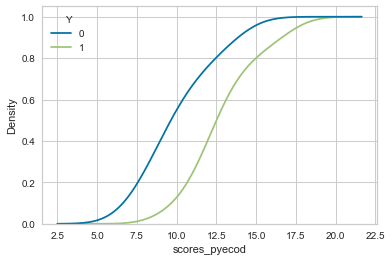

In [16]:
sns.kdeplot(
    data=test, x="scores_pyecod", hue=test.Y,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.77      0.89      0.83        19

    accuracy                           0.79        33
   macro avg       0.80      0.77      0.77        33
weighted avg       0.79      0.79      0.78        33

Gini:  0.5375939849624061
ROC AUC::  0.768796992481203


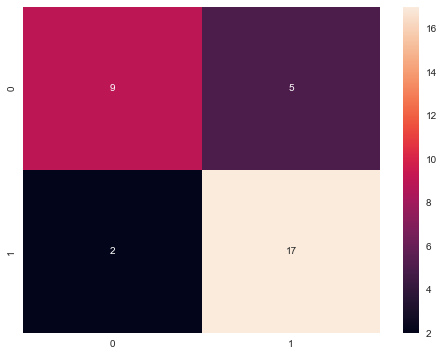

In [17]:
metrics(test.Y, test.pyecod)

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.56      0.63        32
           1       0.71      0.83      0.77        42

    accuracy                           0.72        74
   macro avg       0.72      0.70      0.70        74
weighted avg       0.72      0.72      0.71        74

Gini:  0.3958333333333335
ROC AUC::  0.6979166666666667


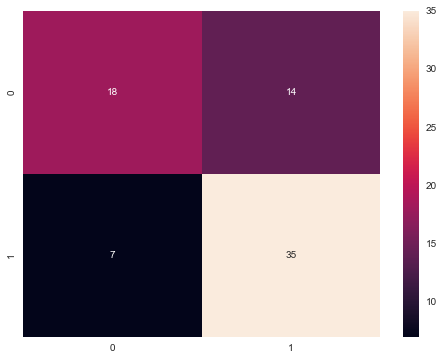

In [18]:
metrics(train.Y, train.pyecod)

### IsolationForest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [11]:
from sklearn.ensemble import IsolationForest

In [12]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=65)

# cv = LeaveOneOut()

forest_s = IsolationForest()
f1sc = make_scorer(f1_score)

ps = {"n_estimators": (100, 256), 
      "max_features": (0.5, 0.7, 0.8, 0.9, 1.0),
      "contamination":(0.49, 0.5)}
search = GridSearchCV(estimator=forest_s, param_grid=ps, scoring='recall', cv=cv)
search.fit(train[VARS], train.Y2)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=65, test_size=0.3,
            train_size=None),
             estimator=IsolationForest(),
             param_grid={'contamination': (0.49, 0.5),
                         'max_features': (0.5, 0.7, 0.8, 0.9, 1.0),
                         'n_estimators': (100, 256)},
             scoring='recall')

In [347]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()

,mean_test_score,std_test_score,params
2,0.700000,0.0,"{'contamination': 0.49, 'max_features': 0.7, '..."
8,0.636364,0.0,"{'contamination': 0.49, 'max_features': 1.0, '..."
16,0.636364,0.0,"{'contamination': 0.5, 'max_features': 0.9, 'n..."
6,0.571429,0.0,"{'contamination': 0.49, 'max_features': 0.9, '..."
5,0.545455,0.0,"{'contamination': 0.49, 'max_features': 0.8, '..."


In [348]:
search.best_estimator_

IsolationForest(contamination=0.49, max_features=0.7)

In [13]:
iforest=IsolationForest(n_estimators=256, max_samples='auto',max_features=0.9, contamination = 0.5, random_state=75)
iforest.fit(train[VARS])

IsolationForest(contamination=0.5, max_features=0.9, n_estimators=256,
                random_state=75)

In [14]:
test['scores_forest']=iforest.decision_function(test[VARS])
test['iForest']=iforest.predict(test[VARS])
test['iForest'] = test['iForest'].apply(lambda x: 1 if x<0 else 0)

In [206]:
train['scores_forest']=iforest.decision_function(train[VARS])
train['iForest']=iforest.predict(train[VARS])
train['iForest'] = train['iForest'].apply(lambda x: 1 if x<0 else 0)

In [207]:
test.Y.value_counts()

1    19
0    14
Name: Y, dtype: int64

<AxesSubplot:xlabel='scores_forest', ylabel='Density'>

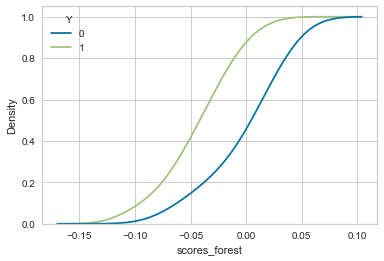

In [208]:
sns.kdeplot(
    data=test, x="scores_forest", hue=test.Y,
    cumulative=True, common_norm=False, common_grid=True,
)

In [209]:
test.head(2)

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y,scores_pyecod,pyecod,scores_forest,iForest,OCSVM,score_OCSVM,LOF,score_LOF,EE,score_EE,Ensemble,CONJUNTO
0,60,22,30,13.2,7.9,52.1,15.1,0.68,0.25,0.15,1,11.388082,1,-0.030567,1,1,-0.438922,1,-0.425592,1,-72.155271,1,test
1,68,37,30,8.5,4.3,51.3,10.0,0.80,0.29,0.41,1,8.856738,0,0.013682,0,1,-0.719097,1,-0.635126,0,24.905902,1,test


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       0.73      1.00      0.84        19

    accuracy                           0.79        33
   macro avg       0.87      0.75      0.76        33
weighted avg       0.84      0.79      0.77        33

Gini:  0.5
ROC AUC::  0.75


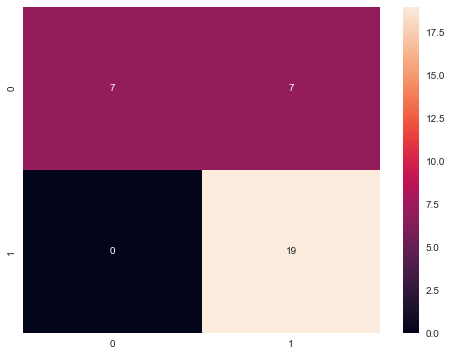

In [15]:
metrics(test.Y, test.iForest)

In [214]:
(17)/(17+2)

0.8947368421052632

Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.59      0.55        32
           1       0.65      0.57      0.61        42

    accuracy                           0.58        74
   macro avg       0.58      0.58      0.58        74
weighted avg       0.59      0.58      0.58        74

Gini:  0.1651785714285714
ROC AUC::  0.5825892857142857


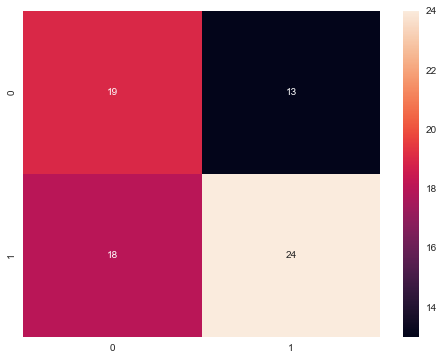

In [215]:
metrics(train.Y, train.iForest)

In [216]:
exp = shap.TreeExplainer(iforest) #Explainer
shap_values = exp.shap_values(train[VARS])  #Calculate SHAP values
shap.initjs()

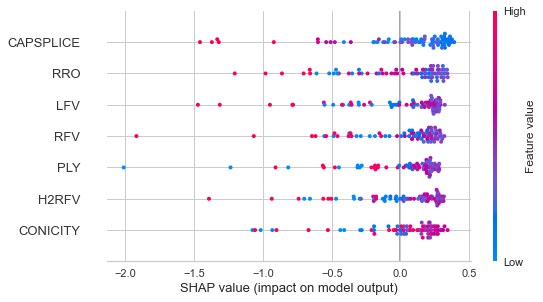

In [217]:
shap.summary_plot(shap_values, train[VARS])

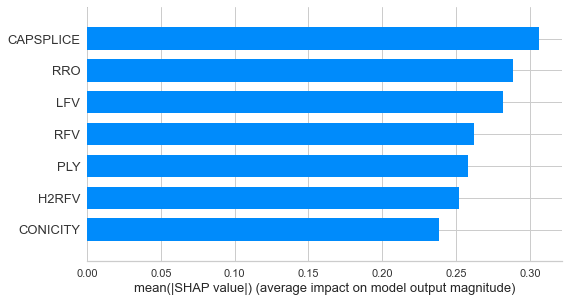

In [218]:
shap.summary_plot(shap_values, train[VARS],plot_type="bar")

In [219]:
shap.force_plot(exp.expected_value, shap_values[2],features =train[VARS].iloc[2,:] ,feature_names =train[VARS].columns)

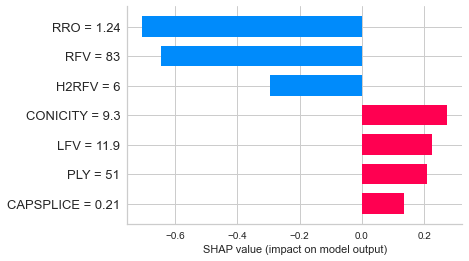

In [220]:
shap.bar_plot(shap_values[2],features =train[VARS].iloc[2,:] ,feature_names =train[VARS].columns)

In [221]:
train.head(10)

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y,Y2,scores_pyecod,pyecod,scores_forest,iForest,OCSVM,score_OCSVM,LOF,score_LOF,EE,score_EE,Ensemble,CONJUNTO
0,46,14,23,4.5,4.3,56.0,13.0,0.77,0.17,0.17,0,1,13.442635,1,-0.052300,1,0,0.080594,0,0.058940,0,26.476168,0,train
1,55,27,35,12.1,9.0,51.3,14.7,0.79,0.20,0.40,1,-1,12.515779,1,-0.034205,1,1,-0.634958,1,-0.886010,1,-77.073255,1,train
2,83,67,6,9.3,8.0,51.0,11.9,1.24,0.21,0.91,1,-1,11.613713,1,-0.047300,1,1,-1.310022,1,-0.884987,1,-58.829767,1,train
3,32,9,19,11.0,11.8,50.4,15.5,0.47,0.17,0.01,1,-1,16.536806,1,-0.043817,1,1,-0.185592,1,-0.204935,1,-3.341477,1,train
4,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40,0,1,7.508050,0,0.047166,0,0,0.326528,0,0.094795,0,29.018739,0,train
5,44,12,24,12.2,7.1,51.6,10.0,0.62,0.25,0.19,1,-1,11.088197,1,0.001093,0,0,0.013108,1,-0.008446,0,0.242800,0,train
6,62,38,3,9.9,7.8,48.9,11.1,0.67,0.33,0.36,0,1,10.896848,1,0.002690,0,1,-0.000080,0,0.026813,1,-2.785672,0,train
7,64,52,15,8.7,11.8,48.3,16.6,0.97,0.35,0.68,1,-1,10.217547,1,0.012062,0,0,0.009933,0,0.038380,0,19.423972,0,train
8,49,18,19,4.7,8.8,56.8,15.1,0.65,0.25,0.20,0,1,11.939949,1,-0.045536,1,0,0.219595,0,0.140578,0,29.928900,0,train
9,55,28,21,8.4,5.1,47.3,12.0,0.89,0.36,0.50,0,1,8.458050,0,0.023139,0,0,0.178490,0,0.141192,0,29.263766,0,train


### AutoEnconder

In [373]:
# from pyod.models.auto_encoder import AutoEncoder

In [374]:
# clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
# clf.fit(train[VARS])

In [375]:
# # Get the outlier scores for the train data
# y_train_scores = clf.decision_scores_
# # Predict the anomaly scores
# y_test_scores = clf.decision_function(test[VARS])  # outlier scores
# y_test_scores = pd.Series(y_test_scores)

In [376]:
# # Plot it!
# import matplotlib.pyplot as plt
# plt.hist(y_test_scores, bins='auto')
# plt.title("Histogram for Model Clf1 Anomaly Scores")
# plt.show()

In [377]:
# df_test = test[VARS].copy()
# df_test['score'] = y_test_scores
# df_test['cluster'] = np.where(df_test['score']<2.5, 0, 1)
# df_test['cluster'].value_counts()
# df_test.groupby('cluster').mean()

In [378]:
# df_test['cluster'].value_counts()

In [286]:
# pd.crosstab(test.Y, df_test['cluster'])

### OneClassSVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

In [146]:
from sklearn import linear_model
from sklearn.svm import OneClassSVM

In [222]:
ocsvm = OneClassSVM(gamma='scale', nu=0.5, kernel='rbf')
ocsvm.fit(train[VARS])

OneClassSVM()

In [223]:
train['OCSVM']=ocsvm.predict(train[VARS])
train['score_OCSVM']=ocsvm.decision_function(train[VARS])
train['OCSVM'] = train['OCSVM'].apply(lambda x: 1 if x<0 else 0)

In [224]:
test['OCSVM']=ocsvm.predict(test[VARS])
test['score_OCSVM']=ocsvm.decision_function(test[VARS])
test['OCSVM'] = test['OCSVM'].apply(lambda x: 1 if x<0 else 0)

<AxesSubplot:xlabel='score_OCSVM', ylabel='Density'>

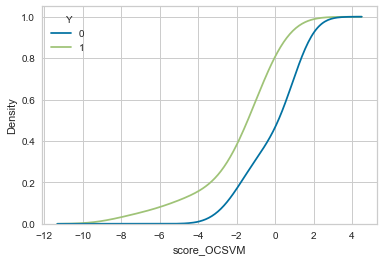

In [225]:
sns.kdeplot(
    data=test, x="score_OCSVM", hue=test.Y,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.57      0.73        14
           1       0.76      1.00      0.86        19

    accuracy                           0.82        33
   macro avg       0.88      0.79      0.80        33
weighted avg       0.86      0.82      0.81        33

Gini:  0.5714285714285714
ROC AUC::  0.7857142857142857


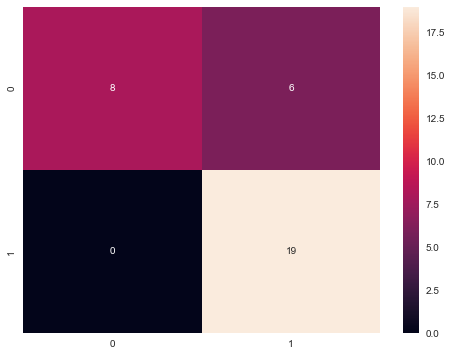

In [226]:
metrics(test.Y, test.OCSVM)

Classification Report: 
               precision    recall  f1-score   support

           0       0.49      0.56      0.52        32
           1       0.62      0.55      0.58        42

    accuracy                           0.55        74
   macro avg       0.55      0.56      0.55        74
weighted avg       0.56      0.55      0.56        74

Gini:  0.11011904761904767
ROC AUC::  0.5550595238095238


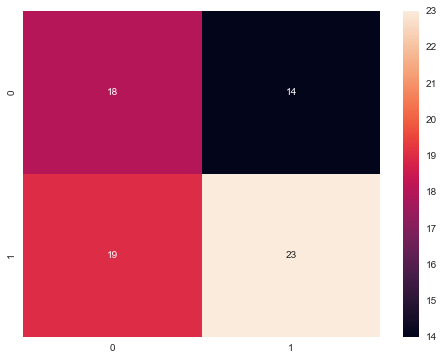

In [227]:
metrics(train.Y, train.OCSVM)

### LocalOutlierFactor

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [188]:
from sklearn.neighbors import LocalOutlierFactor

In [236]:
lof = LocalOutlierFactor(n_neighbors=4, novelty=True, p=2, metric = 'minkowski', contamination=0.5)
lof.fit(train[VARS])

LocalOutlierFactor(contamination=0.5, n_neighbors=4, novelty=True)

In [237]:
train['LOF']=lof.predict(train[VARS])
train['score_LOF']=lof.decision_function(train[VARS])
train['LOF'] = train['LOF'].apply(lambda x: 1 if x<0 else 0)

In [238]:
test['LOF']=lof.predict(test[VARS])
test['score_LOF']=lof.decision_function(test[VARS])
test['LOF'] = test['LOF'].apply(lambda x: 1 if x<0 else 0)

<AxesSubplot:xlabel='score_LOF', ylabel='Density'>

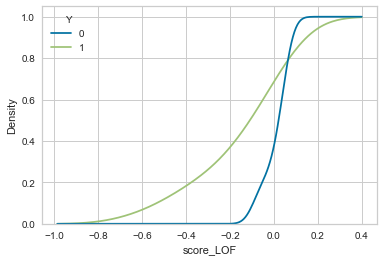

In [239]:
sns.kdeplot(
    data=test, x="score_LOF", hue=test.Y,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.76      0.68      0.72        19

    accuracy                           0.70        33
   macro avg       0.69      0.70      0.69        33
weighted avg       0.71      0.70      0.70        33

Gini:  0.3984962406015038
ROC AUC::  0.6992481203007519


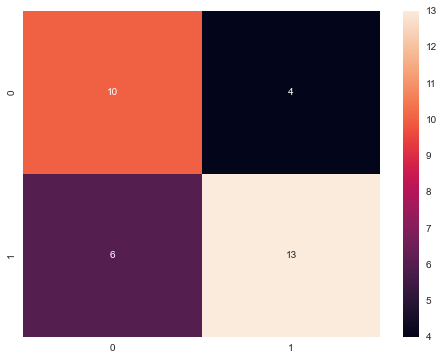

In [240]:
metrics(test.Y, test.LOF)

Classification Report: 
               precision    recall  f1-score   support

           0       0.48      0.81      0.60        32
           1       0.70      0.33      0.45        42

    accuracy                           0.54        74
   macro avg       0.59      0.57      0.53        74
weighted avg       0.61      0.54      0.52        74

Gini:  0.14583333333333326
ROC AUC::  0.5729166666666666


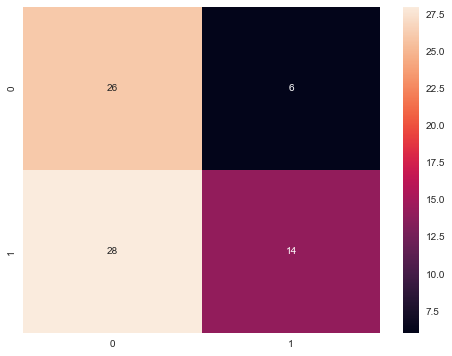

In [241]:
metrics(train.Y, train.LOF)

### EllipticEnvelope

https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html

In [234]:
from sklearn.covariance import EllipticEnvelope

In [242]:
ell = EllipticEnvelope(contamination=0.3)
ell.fit(train[VARS])

EllipticEnvelope(contamination=0.3)

In [243]:
train['EE']=ell.predict(train[VARS])
train['score_EE']=ell.decision_function(train[VARS])
train['EE'] = train['EE'].apply(lambda x: 1 if x<0 else 0)

In [244]:
test['EE']=ell.predict(test[VARS])
test['score_EE']=ell.decision_function(test[VARS])
test['EE'] = test['EE'].apply(lambda x: 1 if x<0 else 0)

<AxesSubplot:xlabel='score_EE', ylabel='Density'>

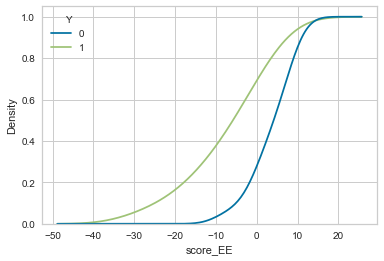

In [245]:
sns.kdeplot(
    data=test, x="score_EE", hue=test.Y,
    cumulative=True, common_norm=False, common_grid=True,
)

In [185]:
# cm = confusion_matrix(test.Y, test.EE)
# cm_df = pd.DataFrame(cm)                      
# plt.figure(figsize=(8,6))  
# sns.heatmap(cm_df, annot=True)
# print("Classification Report: \n", classification_report(test.Y, test.EE))  

Classification Report: 
               precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.76      0.68      0.72        19

    accuracy                           0.70        33
   macro avg       0.69      0.70      0.69        33
weighted avg       0.71      0.70      0.70        33

Gini:  0.3984962406015038
ROC AUC::  0.6992481203007519


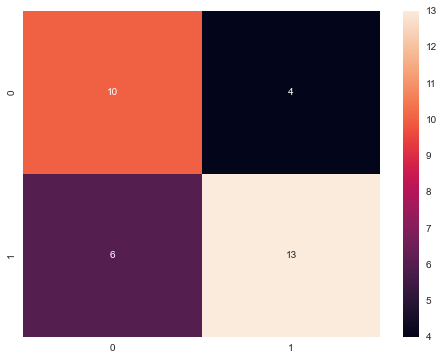

In [246]:
metrics(test.Y, test.EE)

Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.75      0.57        32
           1       0.64      0.33      0.44        42

    accuracy                           0.51        74
   macro avg       0.55      0.54      0.50        74
weighted avg       0.56      0.51      0.50        74

Gini:  0.08333333333333326
ROC AUC::  0.5416666666666666


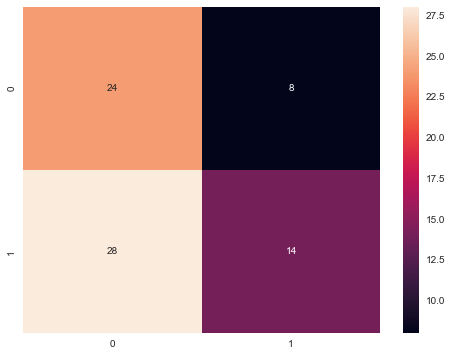

In [247]:
metrics(train.Y, train.EE)

### Curve ROC AUC

In [248]:
from sklearn import metrics
def plot_roc(y_pred, y_test, l):

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)

    
    auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
    plt.plot(fpr,tpr,label=l+ " , AUC="+str(auc))
    plt.xlabel('Taxa falsos positivos')
    plt.ylabel('Taxa verdadeiros positivos')

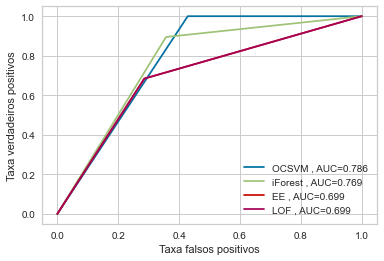

In [249]:
labels = ['OCSVM', 'iForest', "EE", "LOF"]

#set up plotting area
plt.figure(0).clf()

for i, j in enumerate(labels):

    plot_roc(test[j],test.Y, labels[i])


#add legend
plt.legend()

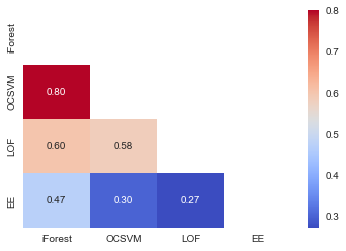

In [250]:
# Concatenate all classifier results
ensemble = pd.concat([test.iForest, test.OCSVM, test.LOF, test.EE],axis=1)


# g= sns.heatmap(ensemble.corr(),annot=True)


corrmat = np.triu(ensemble.corr(method='spearman'))

g = sns.heatmap(ensemble.corr(method='spearman'),cmap="coolwarm",annot=True, mask = corrmat, fmt=".2f")

In [251]:
def voting(c1, c2, c3, c4):
    if c1==1 and c2==1:
        return 1
    elif c3==1 and c2==1:
        return 1
    elif c3==1 and c1==1:
        return 1
    elif c3==1 and c4==1:
        return 1
    elif c2==1 and c4==1:
        return 1
    elif c1==1 and c4==1:
        return 1
    elif c1==1 and c2==1 and c3==1:
        return 1
    elif c1==1 and c2==1 and c3==1 and c4==1:
        return 1
    else: 
        return 0

# Apply the function to the DataFrame
test['Ensemble'] = test.apply(lambda row: voting(row['iForest'], row['OCSVM'], row['LOF'], row['EE']), axis=1)
test['Ensemble'] = test['Ensemble'].astype(int)

train['Ensemble'] = train.apply(lambda row: voting(row['iForest'], row['OCSVM'], row['LOF'], row['EE']), axis=1)
train['Ensemble'] = train['Ensemble'].astype(int)
test.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y,scores_pyecod,pyecod,scores_forest,iForest,OCSVM,score_OCSVM,LOF,score_LOF,EE,score_EE,Ensemble,CONJUNTO
0,60,22,30,13.2,7.9,52.1,15.1,0.68,0.25,0.15,1,11.388082,1,-0.030567,1,1,-0.120159,1,-0.099482,1,-3.416667,1,test
1,68,37,30,8.5,4.3,51.3,10.0,0.80,0.29,0.41,1,8.856738,0,0.013682,0,1,-0.718490,0,0.064814,0,7.948845,0,test
2,74,42,23,6.5,6.9,46.6,11.2,1.06,0.50,0.51,1,14.067508,1,-0.066167,1,1,-0.944739,0,0.030214,1,-12.585423,1,test
3,36,14,20,7.7,4.8,49.9,9.2,0.67,0.26,0.37,0,7.998265,0,0.016130,0,1,-1.182689,1,-0.020499,0,3.504472,1,test
4,60,30,30,6.9,11.3,50.8,15.6,0.91,0.17,0.39,1,10.997506,1,-0.020234,1,1,-0.025187,1,-0.165518,0,0.664057,1,test


Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.74      0.89      0.81        19

    accuracy                           0.76        33
   macro avg       0.77      0.73      0.74        33
weighted avg       0.76      0.76      0.75        33



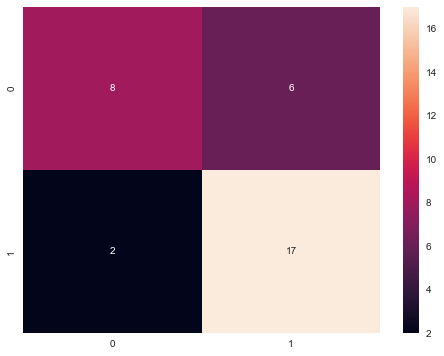

In [252]:
cm = confusion_matrix(test.Y, test.Ensemble)
cm_df = pd.DataFrame(cm)                      
plt.figure(figsize=(8,6))  
sns.heatmap(cm_df, annot=True)
print("Classification Report: \n", classification_report(test.Y, test.Ensemble))  

In [253]:
roc_auc = roc_auc_score(test.Y, test.Ensemble, multi_class = 'ovr', average=None)
gini = 2*roc_auc -1
print("Gini: ",gini)
print("ROC AUC:: ",roc_auc)

Gini:  0.46616541353383445
ROC AUC::  0.7330827067669172


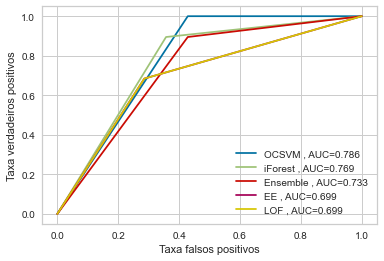

In [254]:
labels = ['OCSVM', 'iForest', 'Ensemble', "EE", "LOF"]
#set up plotting area
plt.figure(0).clf()

for i, j in enumerate(labels):

    plot_roc(test[j],test.Y, labels[i])


#add legend
plt.legend()

### McNemar’s Test for Classifiers

Fail to Reject Null Hypothesis: Classifiers have a similar proportion of errors on the test set. 

Reject Null Hypothesis: Classifiers have a different proportion of errors on the test set.

In [255]:
pd.crosstab(test.LOF, test.iForest)

iForest,0,1
LOF,,
0,10,6
1,1,16


In [256]:
table1 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.LOF, 
                   y_model2=test.iForest)

table1

array([[21,  2],
       [ 5,  5]])

In [257]:
pd.crosstab(test.OCSVM, test.iForest)

iForest,0,1
OCSVM,,
0,8,0
1,3,22


In [258]:
table2 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.OCSVM, 
                   y_model2=test.iForest)

table2

array([[25,  2],
       [ 1,  5]])

In [259]:
pd.crosstab(test.LOF, test.OCSVM)

OCSVM,0,1
LOF,,
0,8,8
1,0,17


In [260]:
table3 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.LOF, 
                   y_model2=test.OCSVM)

table3

array([[21,  2],
       [ 6,  4]])

In [261]:
pd.crosstab(test.LOF, test.EE)

EE,0,1
LOF,,
0,10,6
1,6,11


In [262]:
table4 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.LOF, 
                   y_model2=test.EE)
table4

array([[17,  6],
       [ 6,  4]])

In [263]:
pd.crosstab(test.OCSVM, test.EE)

EE,0,1
OCSVM,,
0,6,2
1,10,15


In [264]:
table5 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.OCSVM, 
                   y_model2=test.EE)

table5

array([[19,  8],
       [ 4,  2]])

In [265]:
pd.crosstab(test.EE, test.iForest)

iForest,0,1
EE,,
0,9,7
1,2,15


In [266]:
table6 = mcnemar_table(y_target=test.Y, 
                   y_model1=test.EE, 
                   y_model2=test.iForest)

table6

array([[20,  3],
       [ 6,  4]])

In [267]:
def test_hip(table):
    # calculate mcnemar test
    result = mcnemar(table, exact=True,  correction=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')


def test_hip2(table):
    result = mcnemar(table, exact=True)
    p = result.pvalue
    return p 

In [268]:
print('LOF vs IsolationForest')
test_hip(table1)
print('OCSVM vs IsolationForest')
test_hip(table2)
print('LOF vs OCSVM')
test_hip(table3)
print('LOF vs EE')
test_hip(table4)
print('OCSVM vs EE')
test_hip(table5)
print('IsolationForest vs EE')
test_hip(table6)

LOF vs IsolationForest
statistic=2.000, p-value=0.453
Same proportions of errors (fail to reject H0)
OCSVM vs IsolationForest
statistic=1.000, p-value=1.000
Same proportions of errors (fail to reject H0)
LOF vs OCSVM
statistic=2.000, p-value=0.289
Same proportions of errors (fail to reject H0)
LOF vs EE
statistic=6.000, p-value=1.000
Same proportions of errors (fail to reject H0)
OCSVM vs EE
statistic=4.000, p-value=0.388
Same proportions of errors (fail to reject H0)
IsolationForest vs EE
statistic=3.000, p-value=0.508
Same proportions of errors (fail to reject H0)


In [269]:
p_value = list()
tables = [table1, table2, table3, table4, table5, table6]
for i in tables:
    p_value.append(test_hip2(i))

In [270]:
p_value

[0.453125, 1.0, 0.2890625, 1.0, 0.3876953125, 0.5078125]

### t-SNE

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [101]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=23).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label=1
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label=0
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

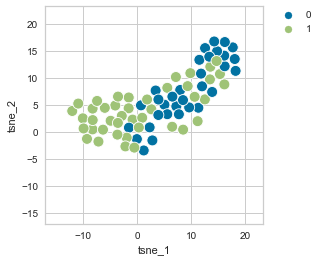

In [102]:
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(train[VARS])
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': train.Y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Gráfico 3D

In [103]:
train['CONJUNTO'] = 'train'
test['CONJUNTO'] = 'test'

In [104]:
df = pd.concat([train, test], axis=0)
df.shape

(107, 24)

In [105]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)

In [106]:
X_reduce = tsne.fit_transform(df[VARS])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 107 samples in 0.002s...
[t-SNE] Computed neighbors for 107 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 107 / 107
[t-SNE] Mean sigma: 8.904813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.149445
[t-SNE] KL divergence after 3000 iterations: 1.104349


In [107]:
tsne_result_df = pd.DataFrame({'tsne_1': X_reduce[:,0], 'tsne_2': X_reduce[:,1], 'tsne_3': X_reduce[:,0]})

tsne_result_df = tsne_result_df.reset_index(drop=True)
data = df.reset_index(drop=True)

data2 = pd.concat([data, tsne_result_df], axis=1)
# data2= data2[data2['CONJUNTO']=='test']
data2.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y,Y2,scores_pyecod,pyecod,scores_forest,iForest,OCSVM,score_OCSVM,LOF,score_LOF,EE,score_EE,Ensemble,CONJUNTO,tsne_1,tsne_2,tsne_3
0,46,14,23,4.5,4.3,56.0,13.0,0.77,0.17,0.17,0,1.0,13.442635,1,-0.001311,1,0,0.049085,0,0.159237,0,29.771024,0,train,-4.731446,-45.636551,-4.731446
1,55,27,35,12.1,9.0,51.3,14.7,0.79,0.20,0.40,1,-1.0,12.515779,1,0.025081,0,1,-0.287792,1,-0.785713,1,-73.778399,1,train,-198.044540,-190.412384,-198.044540
2,83,67,6,9.3,8.0,51.0,11.9,1.24,0.21,0.91,1,-1.0,11.613713,1,-0.016129,1,1,-0.575120,1,-0.784691,1,-55.534911,1,train,113.468620,158.224716,113.468620
3,32,9,19,11.0,11.8,50.4,15.5,0.47,0.17,0.01,1,-1.0,16.536806,1,-0.044236,1,1,-0.075507,1,-0.104638,1,-0.046621,1,train,86.948135,-163.841904,86.948135
4,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40,0,1.0,7.508050,0,0.053810,0,0,0.203920,0,0.195091,0,32.313595,0,train,-30.591209,-449.958344,-30.591209


In [108]:
import snips as snp  # my snippets
# snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
# %matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

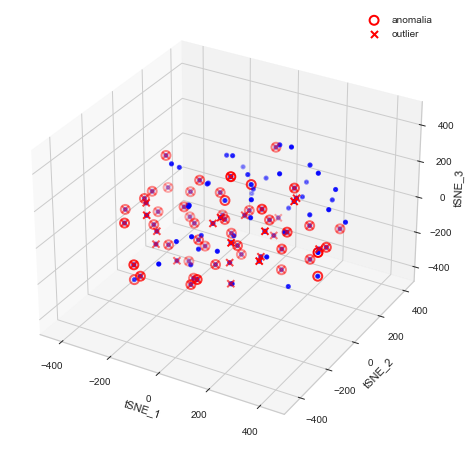

In [109]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")
# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:,0], X_reduce[:,1], zs=X_reduce[:,2], s=10, lw=2, c='blue')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data2.iForest==1, 0], X_reduce[data2.iForest==1, 1], zs=X_reduce[data2.iForest==1, 2], 
           lw=2, facecolors="none", edgecolors="red", s=80, label="anomalia")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data2.Y==1, 0], X_reduce[data2.Y==1, 1], zs=X_reduce[data2.Y==1, 2], 
           lw=2, s=50, marker="x", c="red", label="outlier")
ax.legend()

In [110]:
tsne2 = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)

In [111]:
X_reduce2 = tsne2.fit_transform(train[VARS])

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.001s...
[t-SNE] Computed neighbors for 74 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 10.822609
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.103626
[t-SNE] KL divergence after 1400 iterations: 0.114833


In [112]:
tsne_result_df2 = pd.DataFrame({'tsne_1': X_reduce2[:,0], 'tsne_2': X_reduce2[:,1]})

tsne_result_df2 = tsne_result_df2.reset_index(drop=True)
data3 = train.reset_index(drop=True)

data4 = pd.concat([data3, tsne_result_df2], axis=1)
data4.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y,Y2,scores_pyecod,pyecod,scores_forest,iForest,OCSVM,score_OCSVM,LOF,score_LOF,EE,score_EE,Ensemble,CONJUNTO,tsne_1,tsne_2
0,46,14,23,4.5,4.3,56.0,13.0,0.77,0.17,0.17,0,1,13.442635,1,-0.001311,1,0,0.049085,0,0.159237,0,29.771024,0,train,-0.232977,-4.010383
1,55,27,35,12.1,9.0,51.3,14.7,0.79,0.20,0.40,1,-1,12.515779,1,0.025081,0,1,-0.287792,1,-0.785713,1,-73.778399,1,train,1.431450,-2.806916
2,83,67,6,9.3,8.0,51.0,11.9,1.24,0.21,0.91,1,-1,11.613713,1,-0.016129,1,1,-0.575120,1,-0.784691,1,-55.534911,1,train,6.410812,-5.237829
3,32,9,19,11.0,11.8,50.4,15.5,0.47,0.17,0.01,1,-1,16.536806,1,-0.044236,1,1,-0.075507,1,-0.104638,1,-0.046621,1,train,-2.474420,-3.871645
4,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40,0,1,7.508050,0,0.053810,0,0,0.203920,0,0.195091,0,32.313595,0,train,3.328634,-3.114409


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

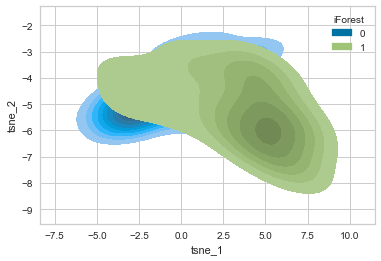

In [113]:
sns.kdeplot(
    data=data4, x="tsne_1", y="tsne_2", hue="iForest", fill=True
)